In [1]:
# !pip install -r requirements.txt

In [2]:
%matplotlib nbagg
from fastmri_recon.data.utils.masking.gen_mask_tf import gen_mask_tf
from fastmri_recon.models.utils.fourier import tf_unmasked_op as tf_fft
from fastmri_recon.models.utils.fourier import tf_unmasked_adj_op as tf_ifft
from fastmri_recon.models.utils.fourier import tf_op as tf_masked_fft
from fastmri_recon.models.utils.fourier import tf_adj_op as tf_masked_ifft
from fastmri_recon.models.utils.masking import _mask_tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import random_shapes
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD, Adam
from tqdm.notebook import tqdm

In [3]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

# The inverse problem

In MRI, data is acquired in the k-space. This k-space $y$ is (in an ideal version) the fourier transform $F$ of the anatomical image $x$: $y = Fx$.

However, because each point (rather each trajectory) in the k-space takes time to acquire, we are going to subsample the fourier coefficients according to a given pattern $\Omega$: $y = F_{\Omega}x$.

This is an ill-posed inverse problem.

## The data

<IPython.core.display.Javascript object>


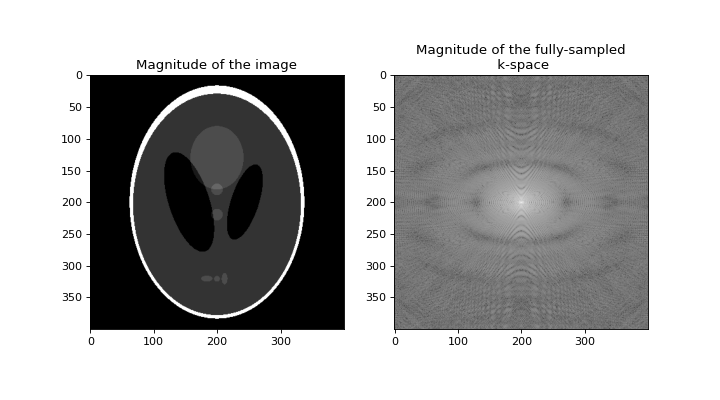

Text(0.5, 1.0, 'Magnitude of the fully-sampled\n k-space')

In [4]:
# let's load our data and see what it looks like
image = np.load('shepp_logan.npy')
# we add a batch and a channel dimension because the ops need it tow work correctly
# indeed in tf, the images are usually in the shape NHWC
# we also need it in complex dtype
image = image.astype(np.complex64)[None, ..., None]
image = tf.convert_to_tensor(image)
kspace = tf_fft(image)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(image)))
axs[0].set_title('Magnitude of the image')
axs[1].imshow(np.log10(np.squeeze(tf.abs(kspace))))
axs[1].set_title('Magnitude of the fully-sampled\n k-space')

A naive solution is to take the inverse fourier transform of the sampled coefficients, with non-sampled coefficients filled to 0. The solution is then called the zero-filled solution.

<IPython.core.display.Javascript object>


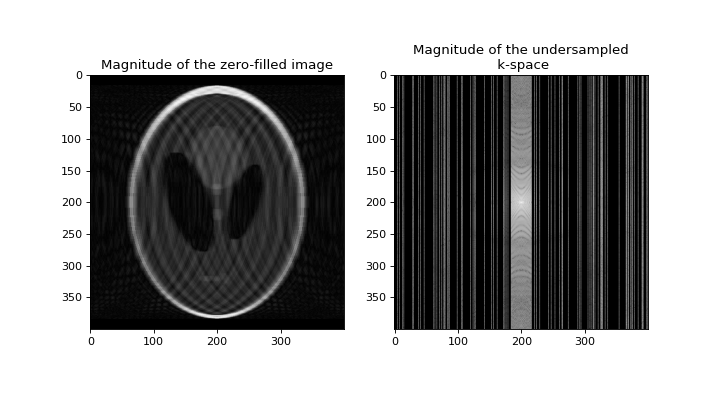

Text(0.5, 1.0, 'Magnitude of the undersampled\n k-space')

In [5]:
# we are going to accelerate the MRI acquisition by a factor 2
mask = gen_mask_tf(kspace[..., 0], accel_factor=4)
masked_kspace = _mask_tf([kspace, mask])
zero_filled_image = tf_ifft(masked_kspace)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(zero_filled_image)))
axs[0].set_title('Magnitude of the zero-filled image')
axs[1].imshow(np.log10(np.squeeze(tf.abs(masked_kspace)) + 1e-5))
axs[1].set_title('Magnitude of the undersampled\n k-space')

## The classical iterative reconstruction

As you can see, the image is strongly aliased. We need a better solution.

For that, we will need to solve an optimisation problem with a data-consistency term and a regularisation term:
$$
argmin_{x \in \mathbb{C}^n} \frac12 \|F_{\Omega} x - y\|_2^2 + \lambda \|x\|_{TV} 
$$

In [6]:
# let's write that in tf
x = tf.Variable(zero_filled_image, trainable=True, name='primal')
lamb = tf.constant(1e-1)
# 1e-2 for AF = 2

def loss():
    data_fidelity = tf.nn.l2_loss(tf.abs(tf_masked_fft([x, mask]) - kspace))
    regularisation = tf.image.total_variation(x)
    return data_fidelity + lamb * regularisation

loss()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1651.623], dtype=float32)>

In [7]:
optimizer = SGD(learning_rate=1e-2)
# 1e-1 for AF = 2
n_iter = 300
verbose = 1
for i_iter in tqdm(range(n_iter)):
    optimizer.minimize(loss, [x])
    if verbose > 0 and i_iter % 10 == 0:
        print(i_iter, loss())

0 tf.Tensor([1584.5928], shape=(1,), dtype=float32)
10 tf.Tensor([1266.7479], shape=(1,), dtype=float32)
20 tf.Tensor([1196.8599], shape=(1,), dtype=float32)
30 tf.Tensor([1166.0322], shape=(1,), dtype=float32)
40 tf.Tensor([1147.7678], shape=(1,), dtype=float32)
50 tf.Tensor([1135.4863], shape=(1,), dtype=float32)
60 tf.Tensor([1126.698], shape=(1,), dtype=float32)
70 tf.Tensor([1120.0366], shape=(1,), dtype=float32)
80 tf.Tensor([1114.9834], shape=(1,), dtype=float32)
90 tf.Tensor([1110.7803], shape=(1,), dtype=float32)
100 tf.Tensor([1107.2772], shape=(1,), dtype=float32)
110 tf.Tensor([1104.2522], shape=(1,), dtype=float32)
120 tf.Tensor([1101.7778], shape=(1,), dtype=float32)
130 tf.Tensor([1099.6326], shape=(1,), dtype=float32)
140 tf.Tensor([1097.7498], shape=(1,), dtype=float32)
150 tf.Tensor([1096.0924], shape=(1,), dtype=float32)
160 tf.Tensor([1094.5652], shape=(1,), dtype=float32)
170 tf.Tensor([1093.11], shape=(1,), dtype=float32)
180 tf.Tensor([1091.7842], shape=(1,), dty

### Qualitative comparison (for the magnitude)

<IPython.core.display.Javascript object>


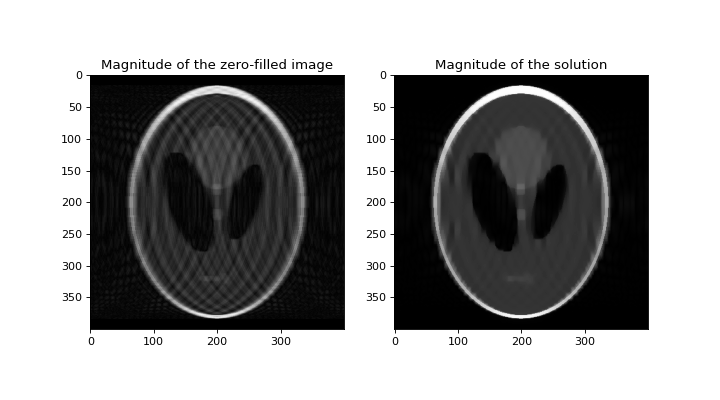

Text(0.5, 1.0, 'Magnitude of the solution')

In [8]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(zero_filled_image)))
axs[0].set_title('Magnitude of the zero-filled image')
axs[1].imshow(np.squeeze(np.abs(x)))
axs[1].set_title('Magnitude of the solution')

### Quantitative metrics (for the magnitude)

In [9]:
print(
    'Zero-filled PSNR: ',
    np.squeeze(tf.image.psnr(tf.abs(image), tf.abs(zero_filled_image), 1.0)),
)
print(
    'Solution PSNR: ',
    np.squeeze(tf.image.psnr(tf.abs(image), tf.abs(x), 1.0)),
)

Zero-filled PSNR:  20.524689
Solution PSNR:  23.36622


In [10]:
print(
    'Zero-filled SSIM: ',
    np.squeeze(tf.image.ssim(tf.abs(image), tf.abs(zero_filled_image), 1.0)),
)
print(
    'Solution SSIM: ',
    np.squeeze(tf.image.ssim(tf.abs(image), tf.abs(x), 1.0)),
)

Zero-filled SSIM:  0.32334068
Solution SSIM:  0.7600873


## The Deep Learning approach

### The model

In [11]:
# an example of the subclassed API, written in OO style
# you also have sequential and functionnal APIs
class ResCNN(Model):
    def __init__(self, n_convs=4, n_filters=8, **kwargs):
        super(ResCNN, self).__init__(**kwargs)
        self.n_convs = n_convs
        self.n_filters = n_filters
        self.convs = [
            Conv2D(n_filters, 3, padding='same', activation='relu')
            for _ in range(n_convs-1)
        ]
        # important to have the last activation linear (i.e. no non-linearity) because 
        # otherwise you can't learn correctly.
        self.convs.append(Conv2D(1, 3, padding='same', activation='linear'))
        
    def call(self, inputs):
        # very simple trick, we could imagine sophisticated complex-valued non-linearity
        res_image = inputs
        for conv in self.convs:
            res_image = conv(res_image)
        reconstructed_image = inputs + res_image
        return reconstructed_image

### The data

In [12]:
def generate_random_shapes(size, n_shapes):
    while True:
        image, _ = random_shapes(
            (size, size),
            max_shapes=n_shapes,
            multichannel=False,
            allow_overlap=True,
            max_size=size,
            shape='ellipse'
        )
        yield image

<IPython.core.display.Javascript object>


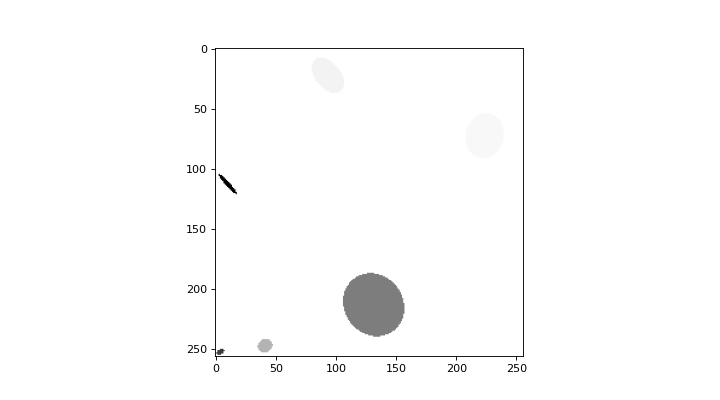

In [13]:
example_training_image = next(generate_random_shapes(256, 20))
plt.figure()
plt.imshow(example_training_image)

In [14]:
batch_size = 8

def from_image_to_training_example(image):
    image = tf.cast(image[None, ...], tf.complex64)
    mask = gen_mask_tf(image, accel_factor=4)
    image = image[..., None]
    kspace = tf_masked_fft([image, mask])
    zero_filled_image = tf_ifft(kspace)
    return tf.abs(zero_filled_image[0]), tf.abs(image[0])
    

image_dataset = tf.data.Dataset.from_generator(
    generate_random_shapes, 
    tf.float32, 
    output_shapes=(256, 256), 
    args=(256, 20),
)
zero_filled_image_dataset = image_dataset.map(
    from_image_to_training_example,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<IPython.core.display.Javascript object>


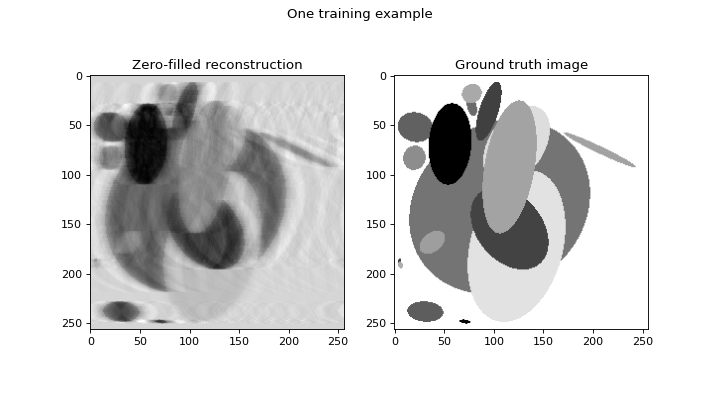

In [15]:
zero_filled_image_train, image_train = next(iter(zero_filled_image_dataset))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(zero_filled_image_train[0]))
axs[0].set_title('Zero-filled reconstruction')
axs[1].imshow(np.squeeze(image_train[0]))
axs[1].set_title('Ground truth image')
fig.suptitle('One training example');

### The training

In [16]:
# metrics
def tf_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

def tf_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

In [17]:
model = ResCNN()
model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[tf_psnr, tf_ssim])
model.fit(
    zero_filled_image_dataset,
    epochs=1,
    steps_per_epoch=2,
    verbose=2,
    validation_data=zero_filled_image_dataset,  # we can have the same generator since it's purely random
    validation_steps=1,
)

Train for 2 steps, validate for 1 steps
2/2 - 3s - loss: 2141.0837 - tf_psnr: -3.3268e+01 - tf_ssim: nan - val_loss: 1476.0925 - val_tf_psnr: -3.1657e+01 - val_tf_ssim: nan


### The evaluation

<IPython.core.display.Javascript object>


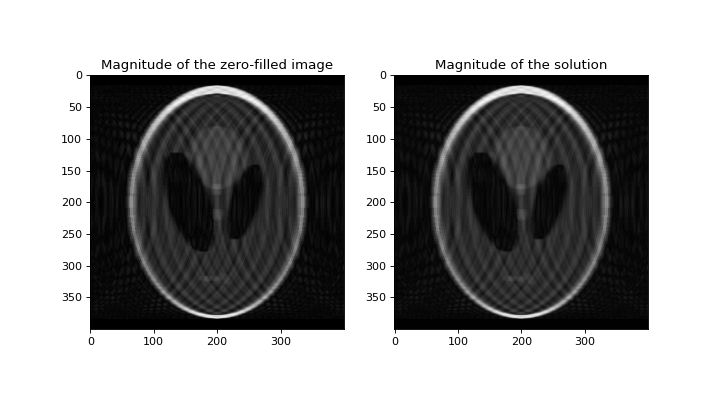

Text(0.5, 1.0, 'Magnitude of the solution')

In [18]:
# qualitative
reconstructed_image_dl = model.predict(tf.abs(zero_filled_image))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(zero_filled_image)))
axs[0].set_title('Magnitude of the zero-filled image')
axs[1].imshow(np.squeeze(reconstructed_image_dl))
axs[1].set_title('Magnitude of the solution')

In [19]:
model.evaluate(tf.abs(zero_filled_image), tf.abs(image))

1/1 [==============================] - 0s 368ms/sample - loss: 0.0097 - tf_psnr: 20.1495 - tf_ssim: 0.3150


[0.009661641903221607, 20.14949, 0.3150321]